# Problem set 2
## Problemas empiricos

Importar los datos para empezar

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, LineString
import multiprocessing
import sqlite3
%matplotlib inline

In [2]:
parcels = pd.read_csv('./data/evanston_parcel_data.csv')

In [3]:
#extract geo data from parcels
polygon_geom = []
for i in range(len(parcels.index)):
    p = Point(parcels.loc[i,'Longitude'], parcels.loc[i,'Latitude'])
    polygon_geom.append(p)

aux_df = gpd.GeoDataFrame(index=parcels.index, crs = {'init': 'epsg:4019'}, geometry= polygon_geom)
parcels = gpd.GeoDataFrame(parcels).merge(aux_df, left_index = True, right_index = True)

In [4]:
# get all zip files in the directory
main_data_list = []
for i in os.listdir('./data'): 
    if 'zip' in i:
        main_data_list.append(i)

In [8]:
# add all the files to a dictionary
# main_data -> m_d
m_d = {}
for i in main_data_list:
    m_d[i.replace('.zip', '')] = gpd.read_file('zip://' + os.getcwd() + '/data/' + i)


In [9]:
(d_l := [i for i in m_d.keys()])

['Major Roads',
 'Lake Michigan',
 'Rail Lines',
 'ctract',
 'cblock',
 'Metra Stops',
 'evanston',
 'El Lines',
 'El Stations']

In [10]:
# set projections
for i in d_l:
    if m_d[i].crs is None:
            m_d[i] = m_d[i].set_crs({"init" : "epsg:4326"})
    else:
            m_d[i] = m_d[i].to_crs({"init" : "epsg:4326"})

### About the data:
- El Lines has two lines, only one has stations
- there is something really wrong with the city data. 



### other data 
We also found a data set that has all the evanston area arrests. We want to use it as a proxy for "safety in the area" 

In [11]:
m_d['arrest'] = gpd.read_file('https://data.cityofevanston.org/resource/25em-v4fn.geojson')
m_d['arrest'] = m_d['arrest'][m_d['arrest'].city.eq('EVANSTON')]

In [12]:
m_d['arrest'].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
m_d['arrest'] = m_d['arrest'][m_d['arrest'].loc[:,'geometry'].notna()]

**Other data we found**

In [14]:
a_data_list = []
for i in os.listdir('./aux_data'): 
    if 'zip' in i:
        a_data_list.append(i)
a_d = {}
for i in a_data_list:
    a_d[i.replace('.zip', '')] = gpd.read_file('zip://' + os.getcwd() + '/aux_data/' + i)


In [15]:
m_d = {**m_d, **a_d}
del(a_d, a_data_list)

In [16]:
#data_list
(d_l := [i for i in m_d.keys()])

['Major Roads',
 'Lake Michigan',
 'Rail Lines',
 'ctract',
 'cblock',
 'Metra Stops',
 'evanston',
 'El Lines',
 'El Stations',
 'arrest',
 'Water bodies',
 'Trees',
 'city',
 'block',
 'tracts',
 'Beaches']

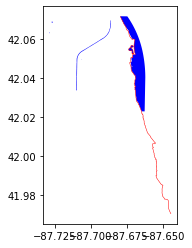

In [17]:
fig, ax = plt.subplots()
m_d['Lake Michigan'].plot(ax = ax, color = 'red',  linewidth = 0.5)
m_d['Water bodies'].plot(ax = ax, color = 'blue',)
plt.show()

In [18]:
# improve the lake Michigan
miny = m_d['Water bodies'].loc[m_d['Water bodies']['name'].eq('Lake Michigan'), :].bounds['miny'].iloc[0]

bounds = list(m_d['Water bodies'].loc[m_d['Water bodies']['name'].eq('Lake Michigan'), :].boundary.iloc[0].coords)

line_min = []
for i in bounds:
    if abs(i[1] - miny) < 0.0001:
        line_min.append(i)

lon_min_left = np.array([i[0] for i in line_min]).argmin()
lon_min_right = np.array([i[0] for i in line_min]).argmax()


maxy = m_d['Water bodies'].loc[m_d['Water bodies']['name'].eq('Lake Michigan'), :].bounds['maxy'].iloc[0]

line_max = []
for i in bounds:
    if abs(i[1] - maxy) < 0.0001:
        line_max.append(i)


lon_max_left = np.array([i[0] for i in line_max]).argmin()
lon_max_right = np.array([i[0] for i in line_max]).argmax()



vertices = [
    tuple(line_max[lon_max_left]),
    tuple(line_min[lon_min_left])
]
counter = len(bounds) - 1 
status = False
result = []
while True:
    if status:

        result.append(bounds[counter])
        if bounds[counter] in vertices:
            break

    else:
        if bounds[counter] in vertices:

            status = True
            result.append(bounds[counter])
    
    counter -= 1 

lon = [i[0] for i in result]
lat = [i[1] for i in result]
polygon_geom = LineString(zip(lon, lat))
crs = {'init': 'epsg:4019'}
m_d['Lake Michigan'] = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 

In [19]:
#coords for shoreline
lake = list(m_d['Lake Michigan'].geometry.iloc[0].coords)  

#we need to add the lagoon which is located here
lagoon = list(m_d['Water bodies'].loc[m_d['Water bodies']['name'].eq('Northwestern Lagoon'), :].boundary.iloc[0].coords)

aux_c = []
aux_p = []
for p,i in enumerate(lake):
    if i in lagoon: 
        aux_c.append(i)
        aux_p.append(p)

#find the points in the lagoon:
lag = [] 
for p,i in enumerate(lagoon):
    if i in aux_c:
        lag.append(p)

#break the lake by the points
# new lagoon
nl = []
#first element : lagoon[lag[0] -1 ]
#last element : lagoon[lag[1] + 1 ]
#order : negative! 

counter = lag[0] - 1
itera = 0 
while counter!= lag[1] - len(lagoon):
    nl.append(lagoon[counter])
    counter -= 1

## now we add the things
result = lake[0:aux_p[0] + 1] + nl + lake[aux_p[1]:]

lon = [i[0] for i in result]
lat = [i[1] for i in result]
polygon_geom = LineString(zip(lon, lat))
crs = {'init': 'epsg:4019'}
m_d['Lake Michigan'] = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 

**a) Begin by creating a map that includes census area identifiers (census blocks,
census tracts), major infrastructure layers (train line, roads) and Lake Michigan
shore line.**

In [23]:
fig, ax = plt.subplots(figsize = (6,8))

# base
m_d['city'].plot(ax = ax, color = "#999999")

#census tracts

m_d['tracts'].plot(ax = ax, column = 'name10', cmap = "Set2", categorical= True)

#census blocks

m_d['cblock'].geometry.boundary.plot(ax = ax, label='blocks', color = '#5840d4', linewidth = 0.5)
#include beaches
m_d['Beaches'].plot(ax= ax, color = 'yellow', label = "Beaches")


#Major roads
m_d['Major Roads'].plot(ax = ax, color = 'black', label = "Main roads")

# Rail Roads
# toca cambiar esto porque sale todo 
m_d['Rail Lines'].plot(ax = ax, color = 'black', linestyle= ':', label = "Rail Lines", marker = 'o')


# Water bodies
m_d['Water bodies'].plot(ax=ax, legend = True, color = 'royalblue')

# El Lines
m_d['El Lines'].plot(ax=ax, color = 'red', linestyle = 'dashdot', label = 'El Lines')

# El stations
m_d['El Stations'].plot(ax=ax, color = 'darkgoldenrod', label = 'El Stations')

plt.ylim(42.015, 42.075)
plt.xlim(-87.75, -87.66)

plt.scatter([],[], marker = 'o', color = "royalblue", label = 'Water bodies')
plt.scatter([],[], marker = 'o', color = "yellow", label = 'Beaches')
plt.plot([],[], ' ', label = 'Census tracts \n in different colors')
plt.title('City of evanston')

plt.tick_params(
    axis='both',       
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False,
    left =  False,
    labelleft = False) 


ax.legend(loc = 6)
plt.savefig('./plots/graph_1.png')
plt.close()

**b) Match the parcel data to the block level file and calculate average assessment
values and building area to floor area at the block level.**

In [21]:
# find parcels outside of the city (defined as census tracts)
aux_0 = [i.replace('.', '') if '.' in i else i + '00' for i in m_d['tracts'].name10.unique()]
aux_1 = [str(i) for i in parcels['Census Tract'].unique()]
missing = [int(i) for i in [i for i in aux_1 if i not in aux_0]]

parcels = parcels.loc[[False if i in missing else True for i in parcels['Census Tract']],:]

#restore index
parcels.reset_index(drop = True, inplace = True)

In [30]:
# find blocks outside the city (same as above )
aux_1 = [str(i) for i in m_d['cblock'].TRACT2000.unique()]
missing = [str(i) for i in [i for i in aux_1 if i not in aux_0]]
m_d['cblock'] = m_d['cblock'].loc[[False if i in missing else True for i in m_d['cblock'].TRACT2000],:] 
m_d['cblock'].reset_index(drop = True, inplace = True)

In [31]:
# correct dtype
m_d['cblock']['TRACT2000'] = m_d['cblock']['TRACT2000'].apply(int)

In [33]:
# use multicore to do the separation:
# each core gets a part of the parcels (by tract)
# each core also gets the polygons corresponding to the blocks on that tract
# they have to keep the correct indexing to re assamble the data

# create a list [blocks, parcels] whithin a tract

complete_list = []

for i in m_d['cblock']['TRACT2000'].unique():
    complete_list.append([
        m_d['cblock'].loc[m_d['cblock']['TRACT2000'].eq(i), ['geometry', 'ID']],
        parcels.loc[parcels['Census Tract'].eq(i), ['geometry']] 
    ])

def check_where(parcel, tract):
    for i in tract.index: 
        if tract.loc[i,'geometry'].contains(parcel):
            return tract.loc[i, 'ID']
    return None

def multiprocessing_func(a_list):
    # unpack the list:
    tract = a_list[0]
    par = a_list[1]
    par['result'] = None
    for i in par.index:
        par.loc[i, 'result'] = check_where(par.loc[i,'geometry'],tract)
    q.put(par.loc[:,['result']])
    
if __name__ == '__main__':
    q = multiprocessing.Queue()  
    processes = []
    for i in complete_list:
        p = multiprocessing.Process(target=multiprocessing_func, 
                                    args=(i,))
        processes.append(p)
        p.start()
    
    
    
    resultado = []    
    for process in processes:
        a = q.get()
        resultado.append(a)
    for process in processes:
        process.join()
        
# now join the results
marker = True
for i in resultado:
    if marker:
        marker = False
        result = i
    else:
        result = result.append(i)
    

In [34]:
result = result.sort_index()
result.rename(columns = {"result":"block"}, inplace = True)
parcels = parcels.merge(result, left_index = True, right_index = True)

In [35]:
# there are 76 parcels that don't have a block, for those we have to search in all the blocks
sum([i is None for i in parcels.block])

76

In [36]:
a_list = [m_d['cblock'].loc[:, ['geometry', 'ID']] , parcels.loc[[i is None for i in parcels.block], ['geometry']]]

tract = a_list[0]
par = a_list[1]
par['result'] = None
for i in par.index:
    par.loc[i, 'result'] = check_where(par.loc[i,'geometry'],tract)


In [37]:
parcels.loc[[i is None for i in parcels.block], ['block']] = par['result']

In [39]:
# now we have to calculate at block level average assessment values and building area to floor area at the block level

parcels['Assessed Value'].isna().sum()

# there are a few missing values that will be ignored (they are not much compared to the sample)


18

In [40]:
# for the ratio building area to floor area there are quite a lot of parcels that do not have buildings on them, therefore, those are not taken into account when making this ratio 

# create new variable with this ratio 

parcels['ratio'] = parcels['Building Square Feet']/parcels['Land Square Feet']

In [41]:
parcels.groupby('block').mean().loc[:,['Assessed Value', 'ratio']]

,Assessed Value,ratio
block,,
39294,485841.379310,0.316965
39295,305691.463415,0.441226
39296,808594.545455,0.362263
39304,357773.962264,0.496605
39305,757390.000000,0.537446
...,...,...
40066,302892.083333,0.228732
40067,359519.423077,0.279256
40068,421614.000000,0.262009


In [42]:
m_d['cblock'].merge(parcels.groupby('block').mean().loc[:,['Assessed Value', 'ratio']], right_index = True, left_on = "ID")

,SP_ID,ID,FIPSSTCO,TRACT2000,BLOCK2000,STFID,geometry,Assessed Value,ratio
3,39293,39294,17031,808702,1001,170318087021001,"POLYGON ((-87.67756 42.05503, -87.68006 42.055...",485841.379310,0.316965
4,39294,39295,17031,808702,1002,170318087021002,"POLYGON ((-87.68006 42.05393, -87.68206 42.053...",305691.463415,0.441226
5,39295,39296,17031,808702,1003,170318087021003,"POLYGON ((-87.68006 42.05393, -87.68006 42.055...",808594.545455,0.362263
13,39303,39304,17031,808702,1011,170318087021011,"POLYGON ((-87.68026 42.05203, -87.68216 42.052...",357773.962264,0.496605
14,39304,39305,17031,808702,1012,170318087021012,"POLYGON ((-87.67766 42.05203, -87.68026 42.052...",757390.000000,0.537446
...,...,...,...,...,...,...,...,...,...
772,40065,40066,17031,810302,3005,170318103023005,"POLYGON ((-87.69496 42.02743, -87.69496 42.026...",302892.083333,0.228732
773,40066,40067,17031,810302,3006,170318103023006,"POLYGON ((-87.69496 42.02656, -87.69271 42.026...",359519.423077,0.279256
774,40067,40068,17031,810302,3007,170318103023007,"POLYGON ((-87.69661 42.02651, -87.69506 42.026...",421614.000000,0.262009
775,40068,40069,17031,810302,3008,170318103023008,"POLYGON ((-87.69661 42.02651, -87.69666 42.024...",445302.400000,0.228246


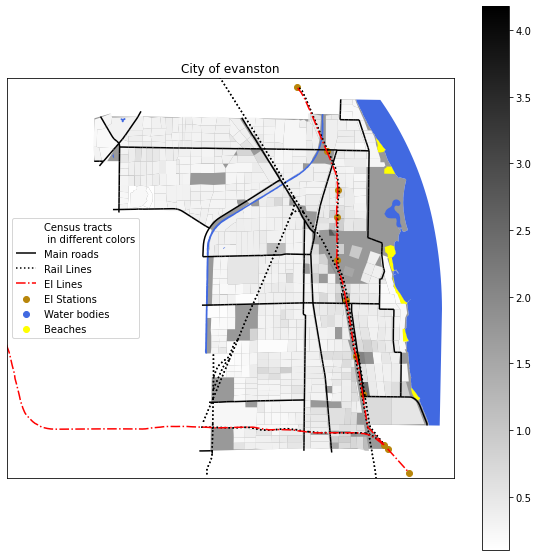

In [43]:
fig, ax = plt.subplots(figsize = (10,10))

# base
m_d['city'].plot(ax = ax, color = "#999999")

#census tracts

#m_d['tracts'].plot(ax = ax, column = 'name10', cmap = "Set2", categorical= True)

#census blocks

m_d['cblock'].merge(parcels.groupby('block').mean().loc[:,['Assessed Value', 'ratio']], right_index = True, left_on = "ID").plot(ax = ax, column = 'ratio', legend = True, cmap = 'binary')


#include beaches
m_d['Beaches'].plot(ax= ax, color = 'yellow', label = "Beaches")


#Major roads
m_d['Major Roads'].plot(ax = ax, color = 'black', label = "Main roads")

# Rail Roads
# toca cambiar esto porque sale todo 
m_d['Rail Lines'].plot(ax = ax, color = 'black', linestyle= ':', label = "Rail Lines", marker = 'o')


# Water bodies
m_d['Water bodies'].plot(ax=ax, legend = True, color = 'royalblue')

# El Lines
m_d['El Lines'].plot(ax=ax, color = 'red', linestyle = 'dashdot', label = 'El Lines')

# El stations
m_d['El Stations'].plot(ax=ax, color = 'darkgoldenrod', label = 'El Stations')

plt.ylim(42.015, 42.075)
plt.xlim(-87.75, -87.66)

plt.scatter([],[], marker = 'o', color = "royalblue", label = 'Water bodies')
plt.scatter([],[], marker = 'o', color = "yellow", label = 'Beaches')
plt.plot([],[], ' ', label = 'Census tracts \n in different colors')
plt.title('City of evanston')

plt.tick_params(
    axis='both',       
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False,
    left =  False,
    labelleft = False) 

ax.legend(loc = 6)
plt.show()

In [313]:
parcels['Total Building Square Feet'].isna().sum()

21810

In [320]:
def search(term, cols):
    result = []
    for i in cols:
        if term in i.lower(): 
            result.append(i)
    return result
    

In [322]:
search('land',  parcels.columns)

['Land Square Feet', 'Prior Tax Year Market Value Estimate (Land)']